# Chest X-Ray Vison

## 1. Problem
This notebook is a simple example of using a pre-trained model to classify chest x-rays. The model is trained on the NIH Chest X-Ray dataset, which contains 112,120 images of chest x-rays. The dataset is split into 14 classes, which are:
- Atelectasis
- Cardiomegaly
- Effusion
- Infiltration
- Mass
- Nodule
- Pneumonia
- Pneumothorax
- Consolidation
- Edema
- Emphysema
- Fibrosis
- Pleural_Thickening
- Hernia
- No Finding

When I receive new chest x-rays, I want to be able to quickly classify them into one of these 14 classes. This will help me to quickly identify the most important x-rays to review.

## 2. Data
The data is available on Kaggle at https://www.kaggle.com/nih-chest-xrays/data. and was downloaded and extracted to the data folder.
Data was distributed into 12 directories


## 3. Evaluation
Evaluation is prediction probability of each class for each image. The evaluation metric is the mean average precision at different intersection over union (IoU) thresholds. The model will be evaluated on the test set.


In [80]:
import tensorflow as tf
import tensorflow_hub as hub

tf.__version__, hub.__version__

('2.9.0', '0.12.0')

## 2. Data exploration / preprocessing

Now we'll prepare the data for the model. We'll do the following:
- Load images paths from the data folder
- Load labels from the data/Data_Entry_2017.csv file and other features
- One-hot encode labels
- Remove nan values if any and remove unused columns
- Split data into train and test sets
- Create tf.data.Dataset from train and test sets

In [81]:
# Dataset was downloaded from https://www.kaggle.com/datasets/nih-chest-xrays/data and extracted to the data folder

# Pandas table of all images (*.png) paths from the data folder
import pandas as pd
import glob

image_paths = glob.glob("data/images_*/images/*.png")
data = pd.DataFrame(image_paths, columns=["image_path"])
# Add column with filename
data["filename"] = data["image_path"].apply(lambda x: x.split("/")[-1])
data

,image_path,filename
0,data/images_006/images/00011723_001.png,00011723_001.png
1,data/images_006/images/00013648_003.png,00013648_003.png
2,data/images_006/images/00011945_002.png,00011945_002.png
3,data/images_006/images/00012342_003.png,00012342_003.png
4,data/images_006/images/00011955_002.png,00011955_002.png
...,...,...
112115,data/images_011/images/00025787_009.png,00025787_009.png
112116,data/images_011/images/00026432_001.png,00026432_001.png
112117,data/images_011/images/00025454_013.png,00025454_013.png
112118,data/images_011/images/00027855_000.png,00027855_000.png


In [82]:
# Concatenation image_paths with data/Data_Entry_2017.csv where filename is the same as first column
data_entry = pd.read_csv("data/Data_Entry_2017.csv")

In [83]:
# row count compare of data and data_entry
print("Images count matches data entries! :)") if data.shape[0] == data_entry.shape[0] else print("Images count doesn't match data entries! :(")

Images count matches data entries! :)


In [84]:
data = pd.merge(data, data_entry, left_on="filename", right_on="Image Index")
data.drop(columns=["filename", "Image Index", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11"], inplace=True)

In [85]:
data.head()

,image_path,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,data/images_006/images/00011723_001.png,Atelectasis|Infiltration,1,11723,62,M,AP
1,data/images_006/images/00013648_003.png,No Finding,3,13648,33,M,AP
2,data/images_006/images/00011945_002.png,No Finding,2,11945,33,F,AP
3,data/images_006/images/00012342_003.png,Mass,3,12342,60,M,AP
4,data/images_006/images/00011955_002.png,Effusion|Infiltration,2,11955,54,F,PA


In [86]:
 # Clear nan "Finding Labels"
data.dropna(subset=["Finding Labels"], inplace=True)

In [87]:
# Convert features "Patient Gender", "View Position" to one-hot encoded columns
data = pd.concat([data, pd.get_dummies(data["Patient Gender"], prefix="Patient Gender")], axis=1)
data = pd.concat([data, pd.get_dummies(data["View Position"], prefix="View Position")], axis=1)

# Convert "Finding Labels" labels to one-hot encoded columns; having in mind that some are logical combinations (class1|class2) of basic labels
data = pd.concat([data, data["Finding Labels"].str.get_dummies(sep="|")], axis=1)

# Drop columns
data.drop(columns=["Patient Gender", "View Position", "Finding Labels"], inplace=True)

In [88]:
# Nan values per column
data.isna().sum()

image_path            0
Follow-up #           0
Patient ID            0
Patient Age           0
Patient Gender_F      0
Patient Gender_M      0
View Position_AP      0
View Position_PA      0
Atelectasis           0
Cardiomegaly          0
Consolidation         0
Edema                 0
Effusion              0
Emphysema             0
Fibrosis              0
Hernia                0
Infiltration          0
Mass                  0
No Finding            0
Nodule                0
Pleural_Thickening    0
Pneumonia             0
Pneumothorax          0
dtype: int64

In [89]:
# How many images are there in each class?
label_counts = data.iloc[:, 8:].sum().sort_values(ascending=False)
label_counts

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

In [90]:
# Median of image count of each class
data.iloc[:, 8:].sum().median()

4667.0

that's a lot of samples! great!

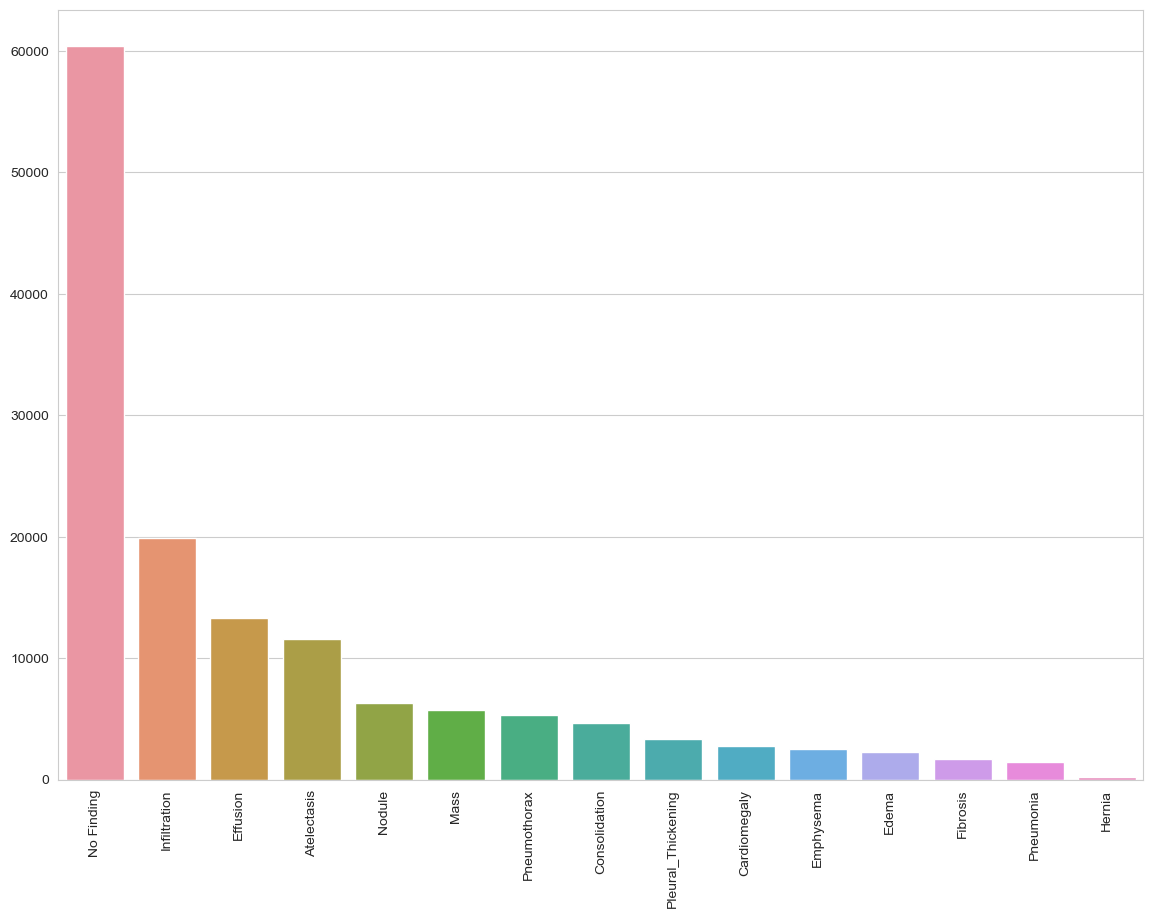

In [91]:
# Plot sum of each class in the dataset. Label columns are [8:]. Sorted by sum. Seaborn bar-plot.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.barplot(x=label_counts.index,
            y=label_counts.values)
plt.xticks(rotation=90)
plt.show();

In [92]:
# Split data into train and test sets

X = data.iloc[:, 0:8]
y = data.iloc[:, 8:]

In [93]:
X.head()

,image_path,Follow-up #,Patient ID,Patient Age,Patient Gender_F,Patient Gender_M,View Position_AP,View Position_PA
0,data/images_006/images/00011723_001.png,1,11723,62,0,1,1,0
1,data/images_006/images/00013648_003.png,3,13648,33,0,1,1,0
2,data/images_006/images/00011945_002.png,2,11945,33,1,0,1,0
3,data/images_006/images/00012342_003.png,3,12342,60,0,1,1,0
4,data/images_006/images/00011955_002.png,2,11955,54,1,0,0,1


In [94]:
y.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


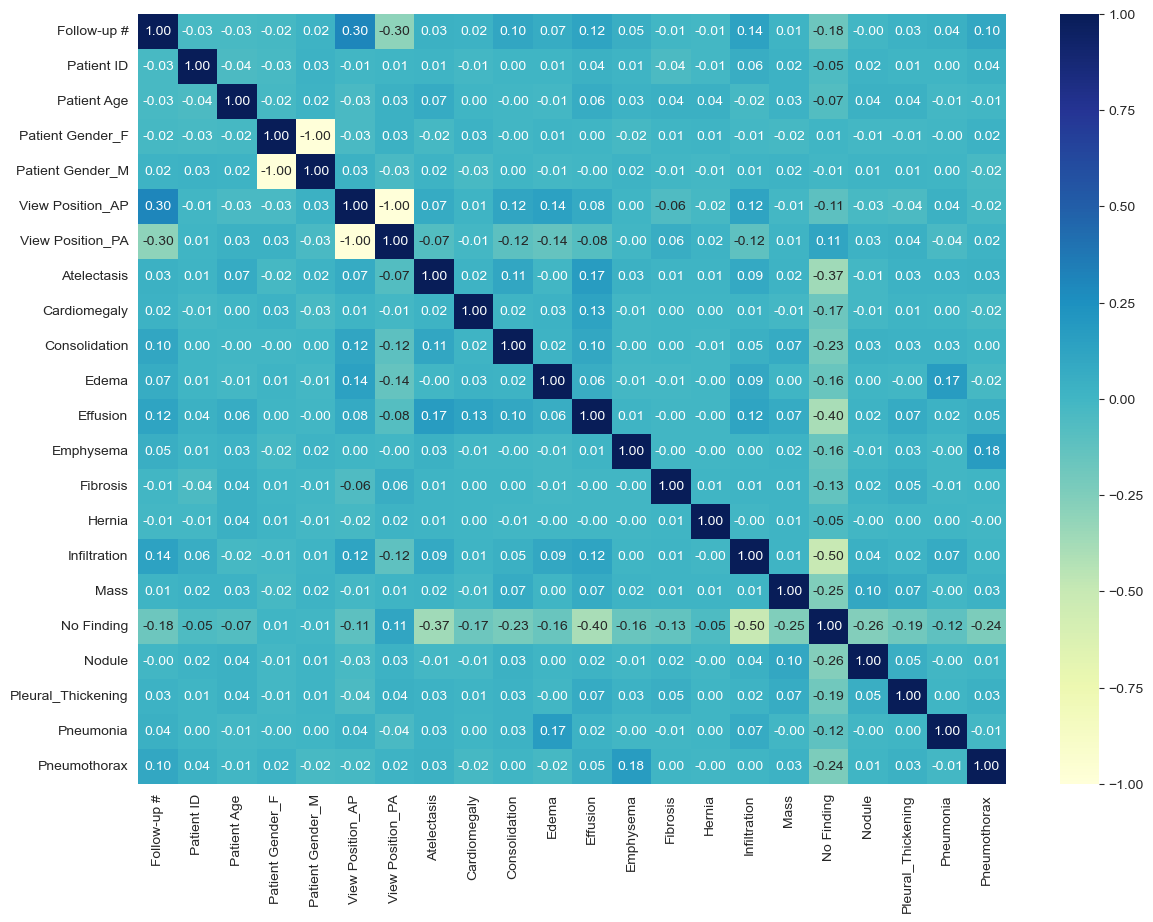

In [95]:
# Correlation matrix of image_paths

plt.figure(figsize=(14, 10))
sns.heatmap(data.iloc[:, 1:].corr(),
            annot=True,
            fmt=".2f",
            cmap="YlGnBu")
plt.show();

In [96]:
# set image count for modeling (for faster training)
IMAGE_COUNT = 1000

In [97]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:IMAGE_COUNT],
                                                      y[:IMAGE_COUNT],
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train), len(X_valid), len(y_train), len(y_valid)

(800, 200, 800, 200)

### Preprocessing images

To preprocess images into Tensors one's going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [98]:
IMG_SIZE = 224
# Create a function to preprocess images
def process_image(image_path, img_size=IMG_SIZE):
    """
    To preprocess images into Tensors I’m going to write a function which does a few things:
    image_path: Image filepath
    img_size: Image size
    :return: Return the modified image
    """

    # Read in an image from image_path
    img = tf.io.read_file(image_path)
    # Turn the png image into numerical Tensor with 3 color channels (Red, Green, Blue)
    img = tf.image.decode_png(img, channels=3)
    # Convert the color channel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to our desired value (img_size, img_size)
    img = tf.image.resize(img, size=[img_size, img_size])

    return img

In [99]:
# Let's test function with a random image
image = process_image(X_train["image_path"].iloc[0]);

In [100]:
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.03137255, 0.03137255, 0.03137255],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02492915, 0.02492915, 0.02492915]],

       [[0.03053221, 0.03053221, 0.03053221],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02492915, 0.02492915, 0.02492915]],

       [[0.02751101, 0.02751101, 0.02751101],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02492915, 0.02492915, 0.02492915]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.  

### Creating data batches

To create data batches, one's going to use the `tf.data` module which can help speed up our modelling process.

Since we're dealing with image data, it's a good idea to read our data in order. There are two main methods we can use to do this:

* `tf.data.Dataset.from_tensor_slices()` - Reads in data from slices (in our case, slices of an array of image paths and labels).

In [107]:
def get_image_label(image_path, label):
    """
    Get image and label
    :param image_path: Image filepath
    :param label: Image label
    :return: Image and label
    """
    image = process_image(image_path)
    return image, label

In [112]:
tpl = get_image_label(X_train.iloc[79]["image_path"], tf.constant(y_train.iloc[79]))
tpl

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.0471194 , 0.0471194 , 0.0471194 ],
         [0.16418687, 0.16418687, 0.16418687],
         [0.39318117, 0.39318117, 0.39318117]],
 
        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.04397811, 0.04397811, 0.04397811],
         [0.15926476, 0.15926476, 0.15926476],
         [0.38099644, 0.38099644, 0.38099644]],
 
        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.04397811, 0.04397811, 0.04397811],
         [0.15574323, 0.15574323, 0.15574323],
         [0.380396  , 0.380396  , 0.380396  ]],
 
        ...,
 
        [[0.24970132, 0.24970132

In [113]:
# Define batch size
BATCH_SIZE = 32
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels

    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we want to shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]), # filepaths
                                                   tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
        return data_batch


In [114]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [115]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 15), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 15), dtype=tf.int64, name=None)))

### Visualizing training data batches

To visualize training data batches, one's going to write a function which does a few things:
1. Take a batch of images and labels from a training dataset as input
2. Unpack the batch into images and labels
3. Plot the images and labels in a grid
4. Return the plotted grid
5. Plot a single image and label from a training dataset
6. Return the plotted image and label
7. Plot a batch of images and labels from a training dataset
8. Return the plotted grid
9. Plot a batch of images and labels from a validation dataset
10. Return the plotted grid
11. Plot a batch of images and labels from a test dataset
12. Return the plotted grid

In [116]:
conditions = y.columns.values
conditions

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [117]:
def get_conditions(label):
    """
    Get conditions from labels
    :param label:
    :return: Conditions string
    """
    return "|".join(conditions[[i for i, v in enumerate(label) if v == 1]])

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Create a function for viewing images in a data batch
def show_n_images(images, labels, n=25):
    """
    Displays a plot of images with their labels.
    :param images: Image
    :param labels: Labels
    :param n: Number of images to display
    :return: Plot of images and labels
    """
    # Create a figure with subplots
    x = int(np.ceil(n / 5))
    plt.figure(figsize=(10, int(10*n/25)))
    # Loop through n (for displaying 25 images)
    for i in range(n):
        # Create subplots (x rows, 5 columns)
        ax = plt.subplot(x, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        title = "|".join(conditions[[i for i, v in enumerate(labels[i]) if v == 1]])
        plt.title(title, fontsize=8)
        # Turn the grid lines off
        plt.axis("off")
        plt.tight_layout()
    plt.show()

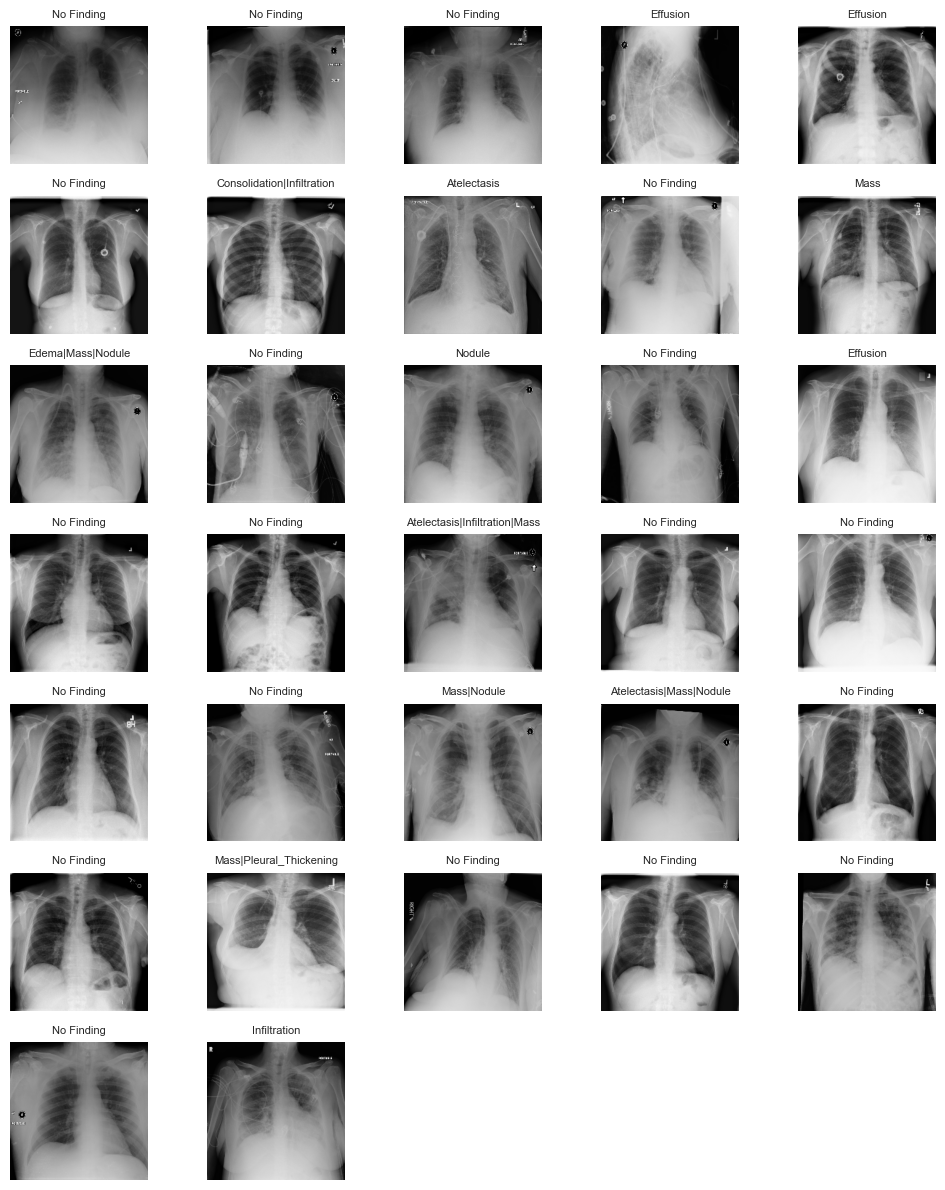

In [119]:
# Now let's visualize a batch of training data
images, labels = next(train_data.as_numpy_iterator())
show_n_images(images, labels, 32);

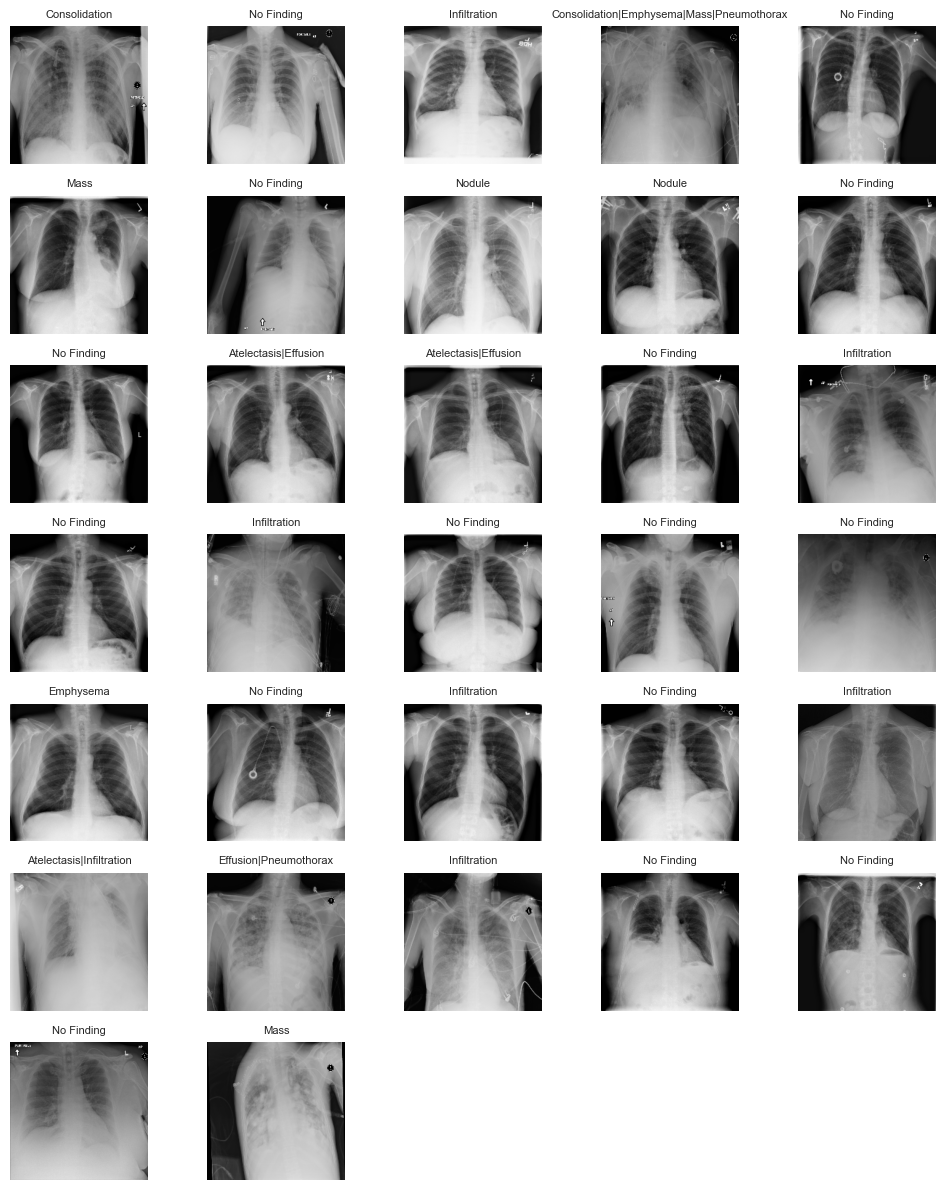

In [120]:
# Now let's visualize our validation set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_n_images(val_images, val_labels, 32)

In [121]:
INPUT_SHAPE = [224, 224, 3]
OUTPUT_SHAPE = len(conditions)
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [122]:
X.columns

Index(['image_path', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender_F', 'Patient Gender_M', 'View Position_AP',
       'View Position_PA'],
      dtype='object')

In [131]:
# Create a multi-classification model that uses combined features 'Patient Age', 'Patient Gender_F', 'Patient Gender_M', 'View Position_AP', 'View Position_PA' with features extracted from the image defined by 'image_path'
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    """
    Create a multi-classification model that uses combined features 'Patient Age', 'Patient Gender_F', 'Patient Gender_M', 'View Position_AP', 'View Position_PA' with features extracted from the image defined by 'image_path'
    :param input_shape: Shape of the input image (all images must be the same shape)
    :param output_shape: Number of output neurons in the output layer
    :param model_url: A TensorFlow Hub feature extraction URL
    :return: A Keras Sequential model with model_url as feature extractor layer and Dense output layer with output_shape
    """

    # Download the pretrained model and save it as a Keras layer
    feat_extract_layer = hub.KerasLayer(model_url,
                                        trainable=False,  # freeze the already learned patterns
                                        name="feature_extraction_layer",
                                        input_shape=input_shape)

    # Create inputs for the model

    # Create input for image
    image_input = tf.keras.layers.Input(shape=INPUT_SHAPE, name="image_input")

    # Create input for 'Patient Age', 'Patient Gender_F', 'Patient Gender_M', 'View Position_AP', 'View Position_PA'
    # other_input = tf.keras.layers.Input(shape=(5,), name="other_features_input")

    # Create a feature extraction layer using the pretrained model
    x = feat_extract_layer(image_input)

    # Combine the outputs of the feature extractor and other input layers using concatenation
    # combined = tf.keras.layers.concatenate([x, other_input])

    # Create an output layer with output_shape neurons
    output = tf.keras.layers.Dense(units=output_shape, activation="softmax", name="output_layer")(combined)

    # Combine the inputs and outputs into a model
    model = tf.keras.Model(inputs=[image_input], outputs=output)

    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [130]:
model = create_model()
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 feature_extraction_layer (Kera  (None, 2048)        23564800    ['image_input[0][0]']            
 sLayer)                                                                                          
                                                                                                  
 other_features_input (InputLay  [(None, 5)]         0           []                               
 er)                                                                                        